In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

In [20]:
path_old = "/lustre/groups/ml01/workspace/eirini/pipeline/data/reports/lipids/merged_results.tsv"
path_new = "/lustre/groups/ml01/workspace/eirini/pipeline/data/reports/lipids_gnn/merged_results.tsv"

Old report columns:
 ['rmse', 'mae', 'r2', 'pearson', 'spearman', 'task', 'method_name', 'featsel', 'method_params', 'hash'] 

New report columns:
 ['rmse', 'mae', 'r2', 'pearson', 'spearman', 'task', 'method_name', 'featsel', 'method_params', 'hash'] 

Merging on keys: ['featsel', 'method_params', 'method_name']
Numeric metrics to compare: ['mae', 'pearson', 'r2', 'rmse', 'spearman']

=== Mean old / new / delta by feature‑selection ===


,mae_old_mean,mae_new_mean,mae_delta_mean,pearson_old_mean,pearson_new_mean,pearson_delta_mean,r2_old_mean,r2_new_mean,r2_delta_mean,rmse_old_mean,rmse_new_mean,rmse_delta_mean,spearman_old_mean,spearman_new_mean,spearman_delta_mean
featsel,,,,,,,,,,,,,,,
hvg,0.262082,0.264414,0.002332,0.925649,0.920477,-0.005172,-0.427732,-0.492520,-0.064788,0.391246,0.400578,0.009332,0.860247,0.858766,-0.001481
hvg_svd,0.327987,0.316504,-0.011483,0.877634,0.890902,0.013268,-1.584493,-1.152188,0.432305,0.534569,0.492443,-0.042126,0.821226,0.823678,0.002452
hvg_svd_graph,0.372082,0.371795,-0.000287,0.854333,0.859704,0.005370,-2.327858,-2.362928,-0.035070,0.626595,0.630458,0.003863,0.813407,0.818284,0.004877
svd,0.232709,0.230559,-0.002150,0.924085,0.926751,0.002665,-1.093377,-1.048654,0.044723,0.364931,0.360456,-0.004475,0.868706,0.872908,0.004202
svd_graph,0.283307,0.285102,0.001796,0.880398,0.864158,-0.016239,-3.076111,-3.837916,-0.761804,0.512441,0.553092,0.040651,0.858572,0.860517,0.001945


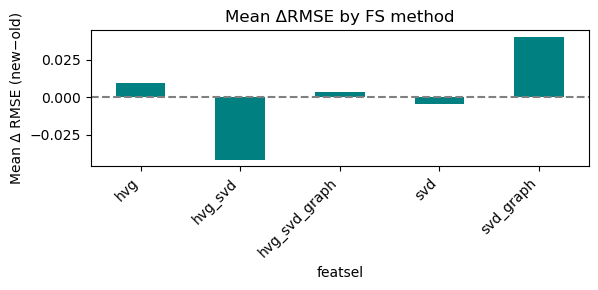

<Figure size 600x300 with 0 Axes>

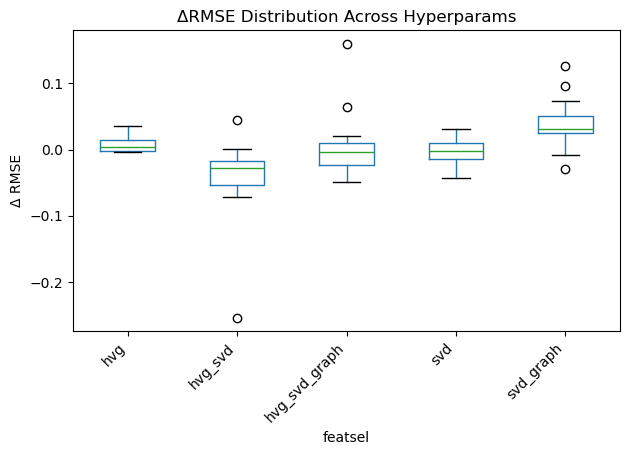

In [21]:
df_old = pd.read_csv(path_old, sep="\t")
df_new = pd.read_csv(path_new, sep="\t")

# 3) Inspect columns so you can sanity‑check
print("Old report columns:\n", df_old.columns.tolist(), "\n")
print("New report columns:\n", df_new.columns.tolist(), "\n")

# 4) If there's a `method_name` column, filter to GNN runs
if "method_name" in df_old:
    df_old = df_old[df_old.method_name == "gnn"]
if "method_name" in df_new:
    df_new = df_new[df_new.method_name == "gnn"]

# 5) Choose merge keys: any of these that appear in both
possible_keys = ["featsel", "method_params", "type", "method_name"]
merge_keys = [k for k in possible_keys if k in df_old.columns and k in df_new.columns]
print("Merging on keys:", merge_keys)

# 6) Identify numeric metrics present in both
num_old = set(df_old.select_dtypes(include=[np.number]).columns)
num_new = set(df_new.select_dtypes(include=[np.number]).columns)
metrics = sorted(list(num_old & num_new))
print("Numeric metrics to compare:", metrics)

# 7) Merge old vs new
merged = df_old.merge(df_new, on=merge_keys, suffixes=("_old","_new"))
if merged.empty:
    raise ValueError("No rows matched on " + str(merge_keys))

# 8) Compute deltas
for m in metrics:
    merged[f"{m}_delta"] = merged[f"{m}_new"] - merged[f"{m}_old"]

# 9) Summarize by featsel
summary = []
for fs, grp in merged.groupby("featsel"):
    row = {"featsel": fs}
    for m in metrics:
        row[f"{m}_old_mean"]   = grp[f"{m}_old"].mean()
        row[f"{m}_new_mean"]   = grp[f"{m}_new"].mean()
        row[f"{m}_delta_mean"] = grp[f"{m}_delta"].mean()
    summary.append(row)
summary_df = pd.DataFrame(summary).set_index("featsel")
print("\n=== Mean old / new / delta by feature‑selection ===")
display(summary_df)

# 10) Bar plot of mean ΔRMSE (if available)
if "rmse_delta_mean" in summary_df:
    ax = summary_df["rmse_delta_mean"].plot.bar(
        figsize=(6,3), color="teal", title="Mean ΔRMSE by FS method")
    ax.axhline(0, color="gray", linestyle="--")
    ax.set_ylabel("Mean Δ RMSE (new−old)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# 11) Boxplot of ΔRMSE distribution
if "rmse_delta" in merged.columns:
    plt.figure(figsize=(6,3))
    merged.boxplot(column="rmse_delta", by="featsel", grid=False)
    plt.suptitle("")  # drop default
    plt.title("ΔRMSE Distribution Across Hyperparams")
    plt.ylabel("Δ RMSE")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


=== Mean Delta by Feature‐Selection ===


,mae_delta_mean,pearson_delta_mean
featsel,,
hvg,0.002332,-0.005172
hvg_svd,-0.011483,0.013268
hvg_svd_graph,-0.000287,0.005370
svd,-0.002150,0.002665
svd_graph,0.001796,-0.016239


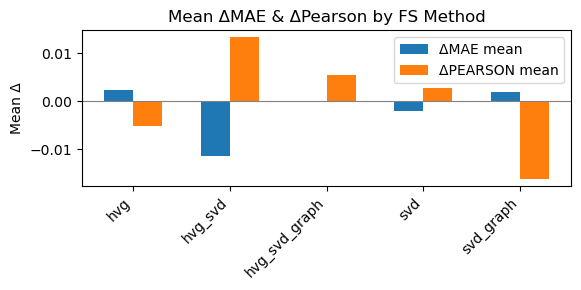

<Figure size 600x300 with 0 Axes>

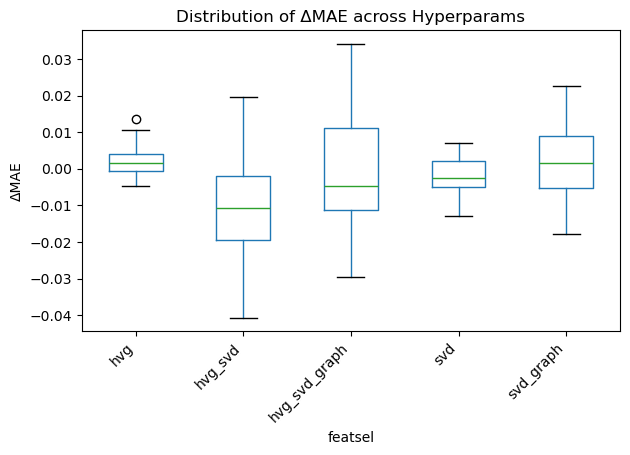

<Figure size 600x300 with 0 Axes>

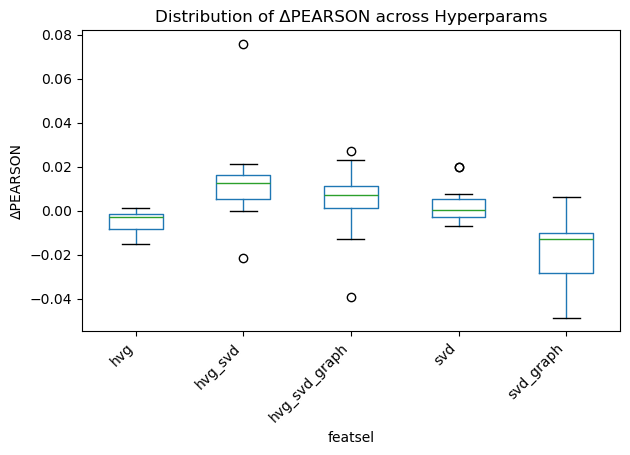

In [22]:
# 1) Compute a small summary of mean deltas by featsel
metrics = ['mae', 'pearson']
summary2 = (
    merged
    .groupby('featsel')
    [[f'{m}_delta' for m in metrics]]
    .mean()
    .rename(columns={f'{m}_delta': f'{m}_delta_mean' for m in metrics})
)
print("=== Mean Delta by Feature‐Selection ===")
display(summary2)

# 2) Bar‐plot the mean deltas
plt.figure(figsize=(6,3))
for i, m in enumerate(metrics):
    plt.bar(
        [x + i*0.3 for x in range(len(summary2))],
        summary2[f'{m}_delta_mean'],
        width=0.3,
        label=f'Δ{m.upper()} mean'
    )
plt.axhline(0, color='gray', linewidth=0.8)
plt.xticks([x+0.15 for x in range(len(summary2))], summary2.index, rotation=45, ha='right')
plt.ylabel('Mean Δ')
plt.title('Mean ΔMAE & ΔPearson by FS Method')
plt.legend()
plt.tight_layout()
plt.show()

# 3) Boxplots to show full distribution of deltas
for m in metrics:
    col = f'{m}_delta'
    if col in merged.columns:
        plt.figure(figsize=(6,3))
        merged.boxplot(column=col, by='featsel', grid=False)
        plt.suptitle('')    # remove the automatic title
        plt.title(f'Distribution of Δ{m.upper()} across Hyperparams')
        plt.ylabel(f'Δ{m.upper()}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
